# **PySpark Assignment: Data Cleaning, Transformation, Analysis, and Prediction**

**Student: Daniela Salazar Fernandez de Lara**
**ID: C091733**

**Dataset Info:**

Name: Flight Delay Dataset

Size: 1.38GB

Source: https://www.kaggle.com/datasets/robikscube/flight-delay-dataset-20182022?select=Combined_Flights_2022.csv

Summary: Information data from flight delays during the year 2022. The dataset contains 80 features, like Origin, Airline, Flight Date, ArrDel15, among others.

# **1. Data Loading and Initial Exploration**

**1.1  Loaingd the dataset into PySpark**


In [1]:
#Importing the relevant libraries

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, isnan
from pyspark.sql.types import FloatType, DoubleType
from functools import reduce
from pyspark.sql.types import FloatType, DoubleType, IntegerType
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
import matplotlib.pyplot as plt


# Initializing Spark session
spark = SparkSession.builder \
    .appName("Assignment 1") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

In [2]:
file_path = "Combined_Flights_2022.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

**1.2 Ensure that the dataset is partitioned appropriately for distributed processing.**

In [3]:
# Repartition the DataFrame to distribute data efficiently across the cluster
df_partitioned = df.repartition(50)

In [4]:
# Verifying the number of partitions
print("Number of partitions:", df_partitioned.rdd.getNumPartitions())

Number of partitions: 50


**1.3 Displaying the schema of the dataset and show the first 10 rows.**


In [5]:
# Displaying the DataFrame schema
df.printSchema()

root
 |-- FlightDate: date (nullable = true)
 |-- Airline: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Cancelled: boolean (nullable = true)
 |-- Diverted: boolean (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- DepTime: double (nullable = true)
 |-- DepDelayMinutes: double (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- ArrTime: double (nullable = true)
 |-- ArrDelayMinutes: double (nullable = true)
 |-- AirTime: double (nullable = true)
 |-- CRSElapsedTime: double (nullable = true)
 |-- ActualElapsedTime: double (nullable = true)
 |-- Distance: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Marketing_Airline_Network: string (nullable = true)
 |-- Operated_or_Branded_Code_Share_Partners: string (nullable = true)
 |

In [6]:
df.show(10)

+----------+--------------------+------+----+---------+--------+----------+-------+---------------+--------+-------+---------------+-------+--------------+-----------------+--------+----+-------+-----+----------+---------+-------------------------+---------------------------------------+------------------------+---------------------------+-------------------------------+-----------------+------------------------+---------------------------+-----------+-------------------------------+---------------+------------------+------------------+--------------------+-----------+---------------+---------------+---------+-------------+----------------+----------------+-------------------+---------+-------------+-------------+-------+--------+--------------------+----------+-------+---------+--------+------+----------+--------+--------+------------------+----------+-------------+------------------+
|FlightDate|             Airline|Origin|Dest|Cancelled|Diverted|CRSDepTime|DepTime|DepDelayMinutes|De

**1.4 Count the total number of rows in the dataset.**

In [7]:
# Counting the total number of records
total_records = df.count()

# Displaying the total number of records
print(f"Total number of records: {total_records}")

Total number of records: 4078318


# **2. Data Cleaning and Transformation**


 Perform data cleaning using PySpark transformations

**2.1 o Handling missing value**

In [8]:
# Counting null values for each column
null_counts = df.select([
    count(when(col(c).isNull(), c)).alias(c) for c in df.columns
])

# Collecting the results into a list
null_counts_list = null_counts.collect()[0].asDict()

# Filtering columns with null values greater than 0 and calculating their percentage
columns_with_nulls = {
    col_name: {
        'count': count,
        'percentage': (count / total_records) * 100 if total_records > 0 else 0
    }
    for col_name, count in null_counts_list.items() if count > 0
}

# Displaying the columns with null counts and percentages
for column, data in columns_with_nulls.items():
    print(f"Column: {column}, Null Count: {data['count']}, Percentage: {data['percentage']:.2f}%")

Column: DepTime, Null Count: 120433, Percentage: 2.95%
Column: DepDelayMinutes, Null Count: 120495, Percentage: 2.95%
Column: DepDelay, Null Count: 120495, Percentage: 2.95%
Column: ArrTime, Null Count: 124239, Percentage: 3.05%
Column: ArrDelayMinutes, Null Count: 133402, Percentage: 3.27%
Column: AirTime, Null Count: 133402, Percentage: 3.27%
Column: ActualElapsedTime, Null Count: 133402, Percentage: 3.27%
Column: Tail_Number, Null Count: 26795, Percentage: 0.66%
Column: DepDel15, Null Count: 120495, Percentage: 2.95%
Column: DepartureDelayGroups, Null Count: 120495, Percentage: 2.95%
Column: TaxiOut, Null Count: 122666, Percentage: 3.01%
Column: WheelsOff, Null Count: 122666, Percentage: 3.01%
Column: WheelsOn, Null Count: 124242, Percentage: 3.05%
Column: TaxiIn, Null Count: 124242, Percentage: 3.05%
Column: ArrDelay, Null Count: 133402, Percentage: 3.27%
Column: ArrDel15, Null Count: 133402, Percentage: 3.27%
Column: ArrivalDelayGroups, Null Count: 133402, Percentage: 3.27%


Removing missing values because they represent less than 5% of our data.

In [9]:
# Dropping records with null values
df_no_nulls = df.na.drop()
new_total_records = df_no_nulls.count()

# Calculating the percentage of new total records from old total records
percentage = (new_total_records / total_records) * 100 if total_records > 0 else 0

# Print results
print(f"New Total number of records: {new_total_records}")
print(f"Old Total number of records: {total_records}")
print(f"Percentage of new records from old records: {percentage:.2f}%")

New Total number of records: 3944916
Old Total number of records: 4078318
Percentage of new records from old records: 96.73%


**2.2 Dealing with duplicate records**

In [10]:
# Grouping by all columns and counting occurrences
duplicates_df = df_no_nulls.groupBy(df_no_nulls.columns).count().filter(col("count") > 1)

# Showing duplicate rows
print("Duplicated records:")
duplicates_df.show()  

Duplicated records:
+----------+-------+------+----+---------+--------+----------+-------+---------------+--------+-------+---------------+-------+--------------+-----------------+--------+----+-------+-----+----------+---------+-------------------------+---------------------------------------+------------------------+---------------------------+-------------------------------+-----------------+------------------------+---------------------------+-----------+-------------------------------+---------------+------------------+------------------+--------------+-----------+---------------+---------------+---------+-------------+----------------+----------------+------------+---------+-------------+-------------+-------+--------+--------------------+----------+-------+---------+--------+------+----------+--------+--------+------------------+----------+-------------+------------------+-----+
|FlightDate|Airline|Origin|Dest|Cancelled|Diverted|CRSDepTime|DepTime|DepDelayMinutes|DepDelay|ArrTim

There are no duplicate records in the dataset.

**2.3 Data Type Conversion**

In this case the dataset already has the correct data types for each column as we can see in the schema of the dataframe created.

**2.4 Filtering out invalid rows**

In [11]:
# Selecting columns with Float or Double data types
float_double_columns = [field.name for field in df_no_nulls.schema.fields 
                        if isinstance(field.dataType, (FloatType, DoubleType))]

# Creating a filter for NaN values in those columns
nan_filter = reduce(lambda x, y: x | y, [isnan(col(c)) for c in float_double_columns])

# Filtering rows with NaN in the specified columns
nan_rows_any = df_no_nulls.filter(nan_filter)

# Showing rows with NaN in the specified columns
nan_rows_any.show()

+----------+-------+------+----+---------+--------+----------+-------+---------------+--------+-------+---------------+-------+--------------+-----------------+--------+----+-------+-----+----------+---------+-------------------------+---------------------------------------+------------------------+---------------------------+-------------------------------+-----------------+------------------------+---------------------------+-----------+-------------------------------+---------------+------------------+------------------+--------------+-----------+---------------+---------------+---------+-------------+----------------+----------------+------------+---------+-------------+-------------+-------+--------+--------------------+----------+-------+---------+--------+------+----------+--------+--------+------------------+----------+-------------+------------------+
|FlightDate|Airline|Origin|Dest|Cancelled|Diverted|CRSDepTime|DepTime|DepDelayMinutes|DepDelay|ArrTime|ArrDelayMinutes|AirTime|

There are no records with invalid values in the numeric columns of our dataset.

# **3. Data Analysis Using Spark SQL**

Register the cleaned DataFrame as a temporary view and perform the following queries using Spark SQL:

In [12]:
final_data = df_no_nulls

# Converting the final_data DataFrame as a temporary view
final_data.createOrReplaceTempView("cleaned_data")

# Performing a SQL query to select all data from the cleaned_data view
cleaned_data_query = "SELECT * FROM cleaned_data"
final_df = spark.sql(cleaned_data_query)

# Showing the first few rows of the cleaned data
final_df.show()

+----------+--------------------+------+----+---------+--------+----------+-------+---------------+--------+-------+---------------+-------+--------------+-----------------+--------+----+-------+-----+----------+---------+-------------------------+---------------------------------------+------------------------+---------------------------+-------------------------------+-----------------+------------------------+---------------------------+-----------+-------------------------------+---------------+------------------+------------------+--------------------+-----------+---------------+---------------+---------+-------------+----------------+----------------+-------------------+---------+-------------+-------------+-------+--------+--------------------+----------+-------+---------+--------+------+----------+--------+--------+------------------+----------+-------------+------------------+
|FlightDate|             Airline|Origin|Dest|Cancelled|Diverted|CRSDepTime|DepTime|DepDelayMinutes|De

**3.1 Aggregation: Calculate summary statistics (e.g., mean, median, standard deviation) of the numerical columns.**

In [13]:

# Identifying numeric columns
numeric_columns = [field.name for field in final_df.schema.fields 
                   if isinstance(field.dataType, (FloatType, DoubleType, IntegerType))]


# Calculating summary statistics
# SQL query for aggregation
summary_query = f"""
SELECT 
    {', '.join([f'AVG({col}) AS avg_{col}' for col in numeric_columns])},
    {', '.join([f'MEDIAN({col}) AS median_{col}' for col in numeric_columns])},
    {', '.join([f'STDDEV({col}) AS stddev_{col}' for col in numeric_columns])}
FROM cleaned_data
"""

# Executing the query to calculate summary statistics
summary_df = spark.sql(summary_query)

# Showing the summary statistics DataFrame
summary_df.show(truncate=False)

+------------------+-----------------+-------------------+-----------------+------------------+-------------------+------------------+------------------+---------------------+-----------------+--------+------------------+-----------------+-----------------+------------------+----------------------------+-----------------------------------+----------------------------+-----------------------------------+-------------------+----------------------+----------------------+-------------------+-----------------+------------------+--------------------+--------------------+------------------+----------------+------------------+------------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+----------------------+------------------+----------------------+-----------------+--------------+----------------------+---------------+--------------+----------------------+--------------+---------------------+------

**3.2 Grouping and filtering: Group data by specific categories and calculate aggregations for each group.**

a) Grouping the data by airline to count the number of flights for each carrier, identifying the top 5 airlines
with the highest flight counts and the bottom 5 with the lowest flight counts for 2022.

In [14]:
# SQL query to count the number of flights by Airline
count_query = """
SELECT 
    Airline, 
    COUNT(Flight_Number_Operating_Airline) AS flight_count
FROM 
    cleaned_data
GROUP BY 
    Airline
ORDER BY 
    flight_count DESC
LIMIT 5
"""

# Executing the query for the top 5 airlines
top_5_airlines_df = spark.sql(count_query)

# Showing the results for the top 5 airlines
print("Top 5 Airlines by Flight Count:")
top_5_airlines_df.show(truncate=False)

# Creating a second query to get the bottom 5 airlines
bottom_query = """
SELECT 
    Airline, 
    COUNT(Flight_Number_Operating_Airline) AS flight_count
FROM 
    cleaned_data
GROUP BY 
    Airline
ORDER BY 
    flight_count ASC
LIMIT 5
"""

# Executing the query for the bottom 5 airlines
bottom_5_airlines_df = spark.sql(bottom_query)

# Showing the results for the bottom 5 airlines
print("Bottom 5 Airlines by Flight Count:")
bottom_5_airlines_df.show(truncate=False)

Top 5 Airlines by Flight Count:
+----------------------+------------+
|Airline               |flight_count|
+----------------------+------------+
|Southwest Airlines Co.|712246      |
|Delta Air Lines Inc.  |500710      |
|American Airlines Inc.|475871      |
|SkyWest Airlines Inc. |430311      |
|United Air Lines Inc. |342929      |
+----------------------+------------+

Bottom 5 Airlines by Flight Count:
+-----------------------------------------+------------+
|Airline                                  |flight_count|
+-----------------------------------------+------------+
|GoJet Airlines, LLC d/b/a United Express |32288       |
|Air Wisconsin Airlines Corp              |38774       |
|Hawaiian Airlines Inc.                   |41821       |
|Commutair Aka Champlain Enterprises, Inc.|42715       |
|Capital Cargo International              |51140       |
+-----------------------------------------+------------+



I created two histograms to visualize the top 5 airlines by flight count and the bottom 5, making it easy to identify the differences between them.

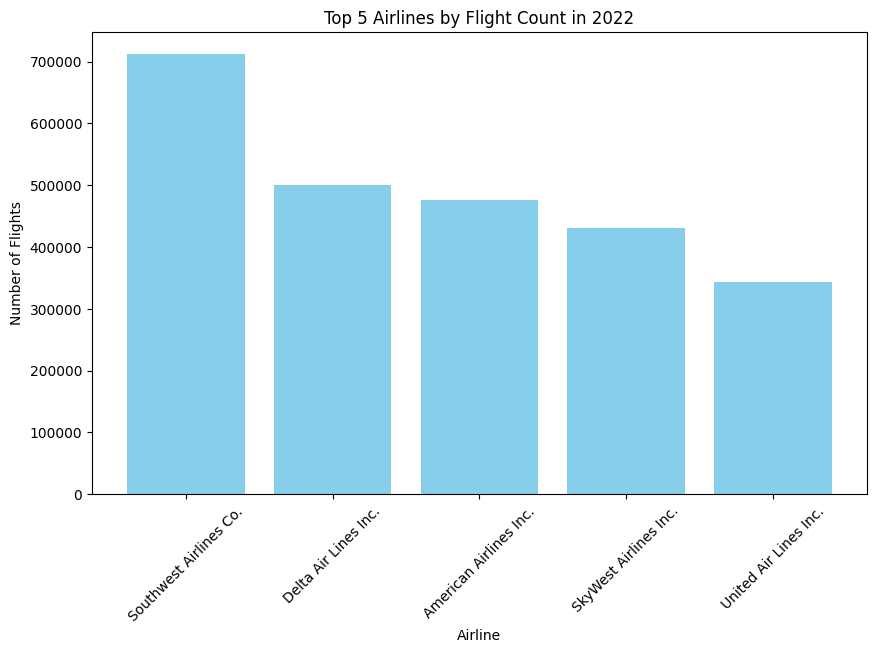

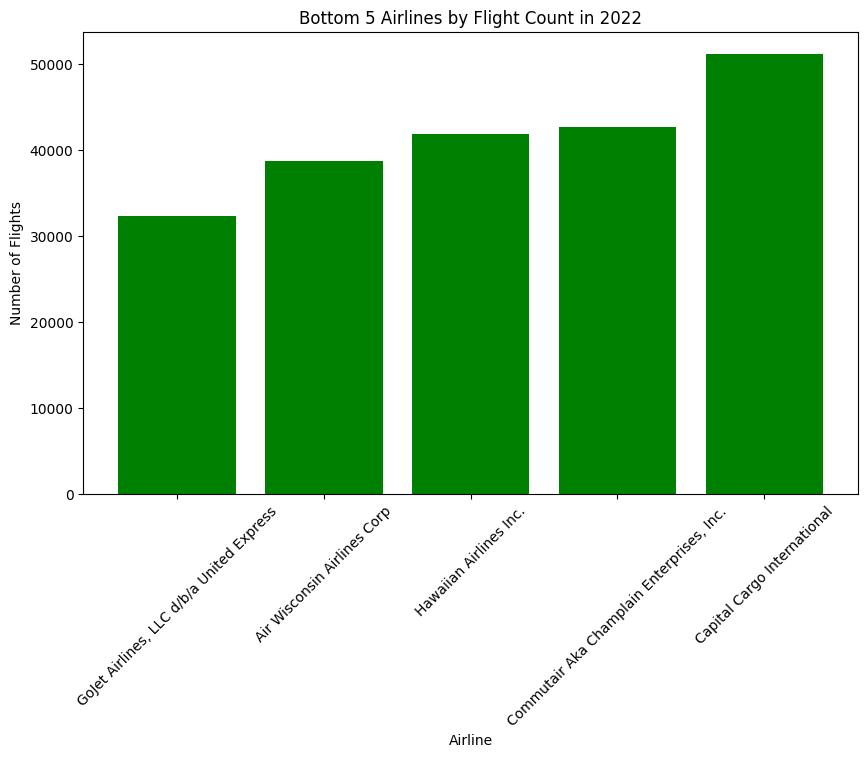

In [15]:

# Converting Spark DataFrames to Pandas DataFrames for plotting
top_5_airlines_pd = top_5_airlines_df.toPandas()
bottom_5_airlines_pd = bottom_5_airlines_df.toPandas()

# Plotting the Top 5 Airlines by Flight Count
plt.figure(figsize=(10, 6))
plt.bar(top_5_airlines_pd['Airline'], top_5_airlines_pd['flight_count'], color='skyblue')
plt.title("Top 5 Airlines by Flight Count in 2022")
plt.xlabel("Airline")
plt.ylabel("Number of Flights")
plt.xticks(rotation=45)
plt.show()

# Plotting the Bottom 5 Airlines by Flight Count
plt.figure(figsize=(10, 6))
plt.bar(bottom_5_airlines_pd['Airline'], bottom_5_airlines_pd['flight_count'], color='green')
plt.title("Bottom 5 Airlines by Flight Count in 2022")
plt.xlabel("Airline")
plt.ylabel("Number of Flights")
plt.xticks(rotation=45)
plt.show()

b) Grouping the data by airline to get the maximum  avergae of DepDelayMinutes, identifying the top 5 airlines
with the highest average delay in minutes and the bottom 5 with the lowest average delay in minutes.

In [16]:
# SQL query to get the maximum DepDelayMinutes by Airline for the top 5
avg_dep_delay_top_query = """
SELECT 
    Airline, 
    AVG(DepDelayMinutes) AS avg_dep_delay
FROM 
    cleaned_data
GROUP BY 
    Airline
ORDER BY 
    avg_dep_delay DESC
LIMIT 5
"""

# Executing the query for the top 5 airlines
top_avg_dep_delay_df = spark.sql(avg_dep_delay_top_query)

# Showing the results for the top 5 airlines
print("Top 5 Airlines by Average Departure Delay Minutes:")
top_avg_dep_delay_df.show(truncate=False)

# Creating a second query to get the bottom 5 airlines based on maximum DepDelayMinutes
avg_dep_delay_bottom_query = """
SELECT 
    Airline, 
    AVG(DepDelayMinutes) AS avg_dep_delay
FROM 
    cleaned_data
GROUP BY 
    Airline
ORDER BY 
    avg_dep_delay ASC
LIMIT 5
"""

# Executing the query for the bottom 5 airlines
bottom_avg_dep_delay_df = spark.sql(avg_dep_delay_bottom_query)

# Showing the results for the bottom 5 airlines
print("Bottom 5 Airlines by Average Departure Delay Minutes:")
bottom_avg_dep_delay_df.show(truncate=False)


Top 5 Airlines by Average Departure Delay Minutes:
+----------------------------------------+------------------+
|Airline                                 |avg_dep_delay     |
+----------------------------------------+------------------+
|JetBlue Airways                         |28.913369286392374|
|Frontier Airlines Inc.                  |23.4853028822085  |
|Allegiant Air                           |22.665417589280644|
|GoJet Airlines, LLC d/b/a United Express|20.106726957383547|
|Mesa Airlines Inc.                      |18.805355872144528|
+----------------------------------------+------------------+

Bottom 5 Airlines by Average Departure Delay Minutes:
+---------------------------+------------------+
|Airline                    |avg_dep_delay     |
+---------------------------+------------------+
|Hawaiian Airlines Inc.     |8.85887472800746  |
|Horizon Air                |8.86154960173787  |
|Alaska Airlines Inc.       |10.069359506932761|
|Envoy Air                  |10.1283311489

I created two histograms to visualize the results, making it easy to identify the differences between them.

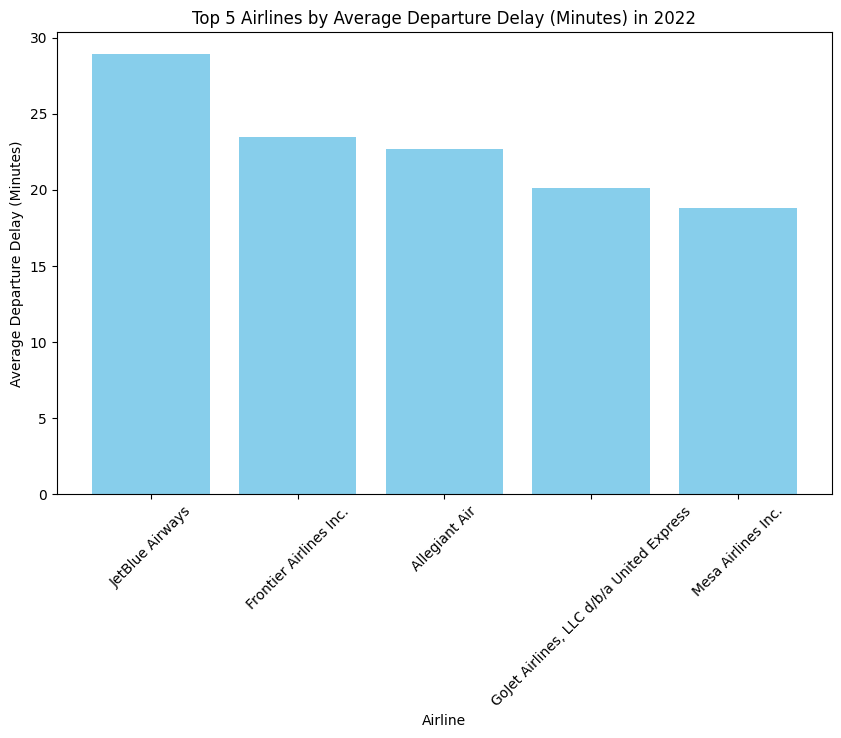

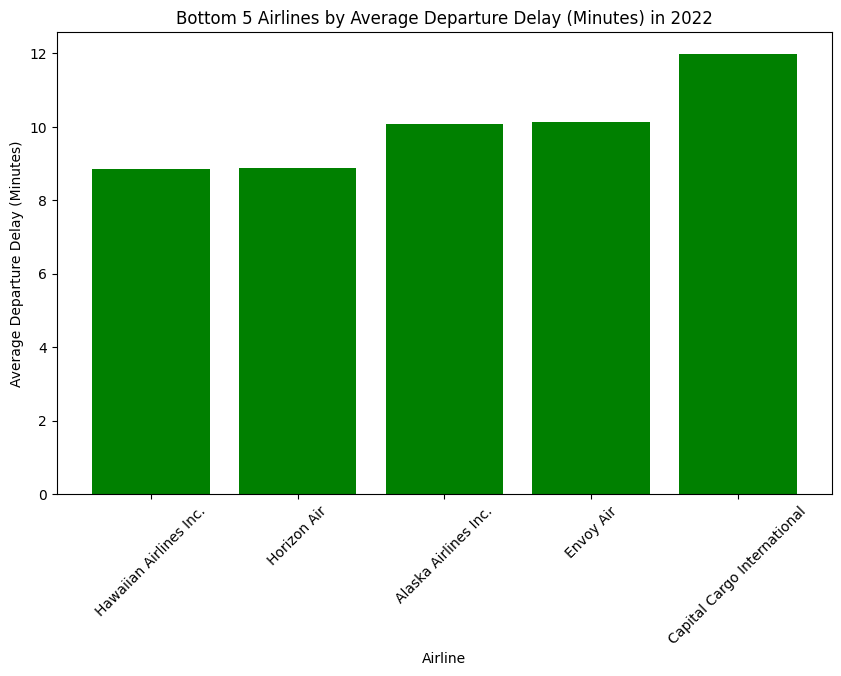

In [17]:
# Converting Spark DataFrames to Pandas DataFrames for plotting
top_avg_dep_delay_pd = top_avg_dep_delay_df.toPandas()
bottom_avg_dep_delay_pd = bottom_avg_dep_delay_df.toPandas()

# Plotting the Top 5 Airlines by Average Departure Delay
plt.figure(figsize=(10, 6))
plt.bar(top_avg_dep_delay_pd['Airline'], top_avg_dep_delay_pd['avg_dep_delay'], color='skyblue')
plt.title("Top 5 Airlines by Average Departure Delay (Minutes) in 2022")
plt.xlabel("Airline")
plt.ylabel("Average Departure Delay (Minutes)")
plt.xticks(rotation=45)
plt.show()

# Plotting the Bottom 5 Airlines by Average Departure Delay
plt.figure(figsize=(10, 6))
plt.bar(bottom_avg_dep_delay_pd['Airline'], bottom_avg_dep_delay_pd['avg_dep_delay'], color='green')
plt.title("Bottom 5 Airlines by Average Departure Delay (Minutes) in 2022")
plt.xlabel("Airline")
plt.ylabel("Average Departure Delay (Minutes)")
plt.xticks(rotation=45)
plt.show()

c) Grouping the data by airline to get the count of flights that ahd been delayed, identifying the top 5 airlines
with the highest count of delayed flights and the bottom 5 with the lowest count.

In [18]:
# SQL query for the top 5 OriginCityNames with non-zero DepDelayMinutes
top_5_query = """
SELECT 
    Airline, 
    OriginCityName, 
    COUNT(*) AS non_zero_dep_delay_count
FROM 
    cleaned_data
WHERE 
    DepDelayMinutes <> 0
GROUP BY 
    Airline, 
    OriginCityName
ORDER BY 
    non_zero_dep_delay_count DESC
LIMIT 5
"""

# Creating SQL query for the bottom 5 OriginCityNames with non-zero DepDelayMinutes
bottom_5_query = """
SELECT 
    Airline, 
    OriginCityName, 
    COUNT(*) AS non_zero_dep_delay_count
FROM 
    cleaned_data
WHERE 
    DepDelayMinutes <> 0
GROUP BY 
    Airline, 
    OriginCityName
ORDER BY 
    non_zero_dep_delay_count ASC
LIMIT 5
"""

# Executing the top 5 query
top_5_df = spark.sql(top_5_query)

# Executing the bottom 5 query
bottom_5_df = spark.sql(bottom_5_query)

# Showing the results for top 5
print("Top 5 OriginCityNames with Non-zero Departure Delay by Airline:")
top_5_df.show(truncate=False)

# Showing the results for bottom 5
print("Bottom 5 OriginCityNames with Non-zero Departure Delay by Airline:")
bottom_5_df.show(truncate=False)

Top 5 OriginCityNames with Non-zero Departure Delay by Airline:
+----------------------+---------------------+------------------------+
|Airline               |OriginCityName       |non_zero_dep_delay_count|
+----------------------+---------------------+------------------------+
|Delta Air Lines Inc.  |Atlanta, GA          |47916                   |
|American Airlines Inc.|Dallas/Fort Worth, TX|36048                   |
|Southwest Airlines Co.|Denver, CO           |32821                   |
|Southwest Airlines Co.|Chicago, IL          |28610                   |
|Southwest Airlines Co.|Las Vegas, NV        |26855                   |
+----------------------+---------------------+------------------------+

Bottom 5 OriginCityNames with Non-zero Departure Delay by Airline:
+-----------------------------------------+----------------+------------------------+
|Airline                                  |OriginCityName  |non_zero_dep_delay_count|
+-----------------------------------------+-----

I created two histograms to visualize the results, making it easy to identify the differences between them.

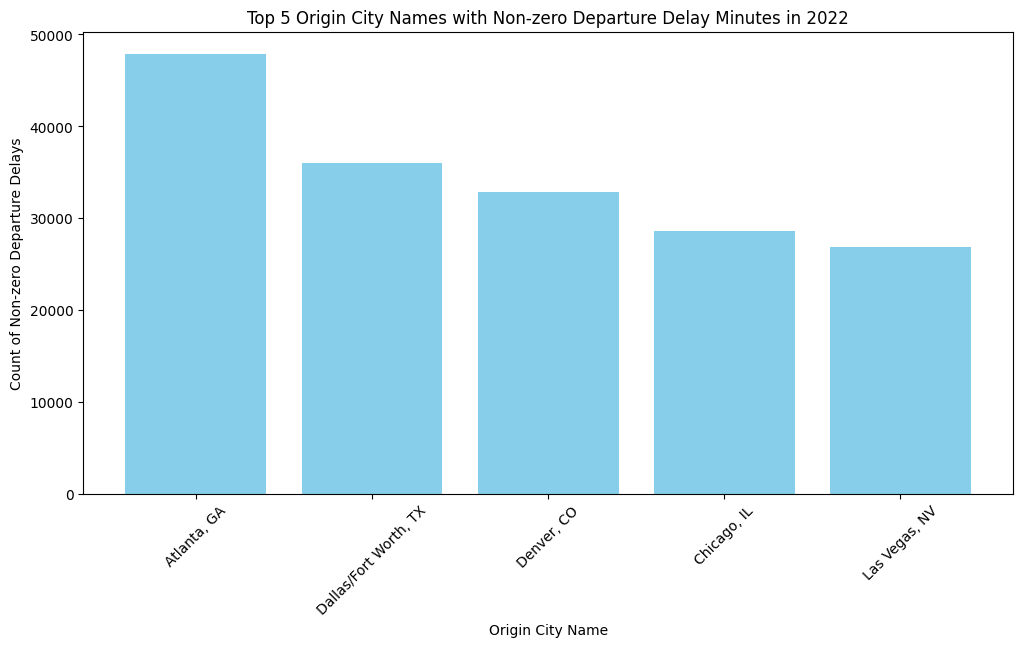

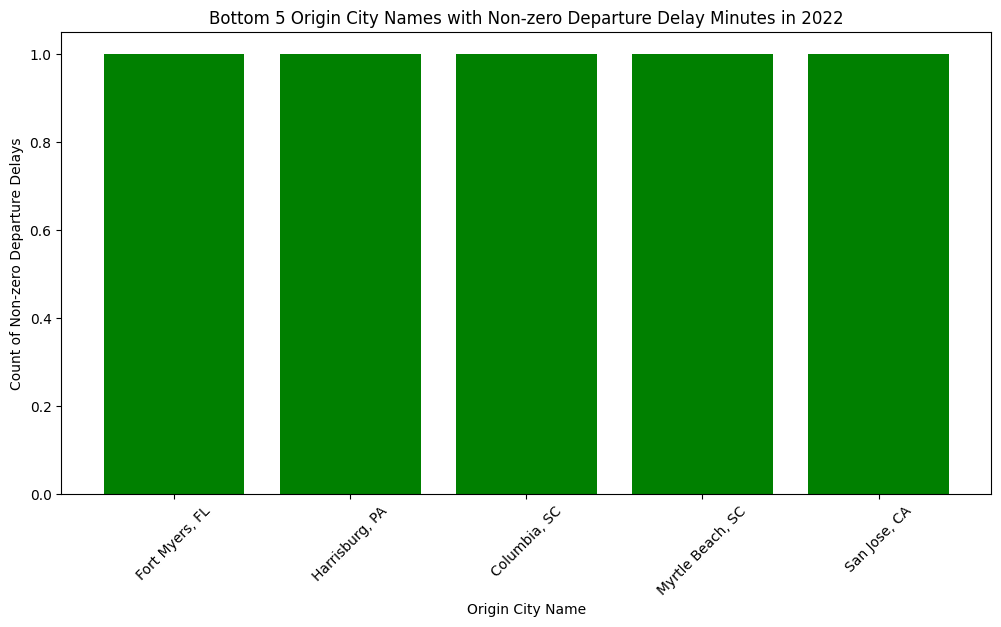

In [19]:
# Converting Spark DataFrames to Pandas DataFrames for plotting
top_5_pd = top_5_df.toPandas()
bottom_5_pd = bottom_5_df.toPandas()

# Plotting the Top 5 OriginCityNames with Non-zero Departure Delay Minutes
plt.figure(figsize=(12, 6))
plt.bar(top_5_pd['OriginCityName'], top_5_pd['non_zero_dep_delay_count'], color='skyblue')
plt.title("Top 5 Origin City Names with Non-zero Departure Delay Minutes in 2022")
plt.xlabel("Origin City Name")
plt.ylabel("Count of Non-zero Departure Delays")
plt.xticks(rotation=45)
plt.show()

# Plotting the Bottom 5 OriginCityNames with Non-zero Departure Delay Minutes
plt.figure(figsize=(12, 6))
plt.bar(bottom_5_pd['OriginCityName'], bottom_5_pd['non_zero_dep_delay_count'], color='green')
plt.title("Bottom 5 Origin City Names with Non-zero Departure Delay Minutes in 2022")
plt.xlabel("Origin City Name")
plt.ylabel("Count of Non-zero Departure Delays")
plt.xticks(rotation=45)
plt.show()

**3.3 Joins**

Are not applicable for our dataset.


s**3..
Time-based analy**

m
.
 Grouping the data by airline to compare the average departure delay by quarter, identifying the top 5 airlines with the highest increases in delay between quarters and the top 5 airlines with the greatest reductions in delay time.

In [20]:
# SQL Query to find airlines with average departure delay comparison by quarter
avg_delay_comparison_query = """
WITH QuarterlyAvg AS (
    SELECT 
        QUARTER(FlightDate) AS Quarter,
        Airline,
        AVG(DepDelayMinutes) AS avg_dep_delay
    FROM 
        cleaned_data
    GROUP BY 
        QUARTER(FlightDate),
        Airline
),
PreviousQuarterAvg AS (
    SELECT 
        a.Airline,
        a.Quarter,
        a.avg_dep_delay AS current_avg,
        b.avg_dep_delay AS previous_avg
    FROM 
        QuarterlyAvg a
    LEFT JOIN 
        QuarterlyAvg b 
    ON 
        a.Airline = b.Airline 
        AND a.Quarter = b.Quarter + 1  -- Comparing current quarter with the previous quarter
)

SELECT 
    Airline,
    Quarter,
    current_avg AS avg_dep_delay_current,
    previous_avg AS avg_dep_delay_previous,
    (current_avg - previous_avg) AS increase_count_minutes
FROM 
    PreviousQuarterAvg
WHERE 
    previous_avg IS NOT NULL -- Exclude rows with no previous data
ORDER BY 
    increase_count_minutes DESC
LIMIT 5
"""

# Executing the average delay comparison query
avg_delay_comparison_df = spark.sql(avg_delay_comparison_query)

# Showing the results
print("Airlines Average Departure Delay Comparison by Quarter:")
avg_delay_comparison_df.show(truncate=False)


Airlines Average Departure Delay Comparison by Quarter:
+---------------------------+-------+---------------------+----------------------+----------------------+
|Airline                    |Quarter|avg_dep_delay_current|avg_dep_delay_previous|increase_count_minutes|
+---------------------------+-------+---------------------+----------------------+----------------------+
|American Airlines Inc.     |2      |19.3941027621143     |13.514440902715798    |5.879661859398503     |
|American Airlines Inc.     |3      |23.65364058292627    |19.3941027621143      |4.259537820811968     |
|Allegiant Air              |3      |26.947135842880524   |23.227475151671616    |3.719660691208908     |
|Southwest Airlines Co.     |3      |19.71086067168891    |16.17386082433604     |3.5369998473528703    |
|Air Wisconsin Airlines Corp|3      |12.911543287327477   |9.485153764581124     |3.4263895227463532    |
+---------------------------+-------+---------------------+----------------------+--------------

In [21]:
# SQL query to find airlines with average departure delay comparison by quarter (bottom)
avg_delay_comparison_bottom_query = """
WITH QuarterlyAvg AS (
    SELECT 
        QUARTER(FlightDate) AS Quarter,
        Airline,
        AVG(DepDelayMinutes) AS avg_dep_delay
    FROM 
        cleaned_data
    GROUP BY 
        QUARTER(FlightDate),
        Airline
),
PreviousQuarterAvg AS (
    SELECT 
        a.Airline,
        a.Quarter,
        a.avg_dep_delay AS current_avg,
        b.avg_dep_delay AS previous_avg
    FROM 
        QuarterlyAvg a
    LEFT JOIN 
        QuarterlyAvg b 
    ON 
        a.Airline = b.Airline 
        AND a.Quarter = b.Quarter + 1  -- Comparing current quarter with the previous quarter
)

SELECT 
    Airline,
    Quarter,
    current_avg AS avg_dep_delay_current,
    previous_avg AS avg_dep_delay_previous,
    (previous_avg - current_avg) AS decrease_count_minutes
FROM 
    PreviousQuarterAvg
WHERE 
    previous_avg IS NOT NULL -- Exclude rows with no previous data
ORDER BY 
    decrease_count_minutes DESC  -- Ordering by the greatest decrease
LIMIT 5
"""

# Executing the average delay comparison query for bottom
avg_delay_comparison_bottom_df = spark.sql(avg_delay_comparison_bottom_query)

# Showing the results
print("Airlines Average Departure Delay Comparison by Quarter (Bottom 5):")
avg_delay_comparison_bottom_df.show(truncate=False)

Airlines Average Departure Delay Comparison by Quarter (Bottom 5):
+----------------------------------------+-------+---------------------+----------------------+----------------------+
|Airline                                 |Quarter|avg_dep_delay_current|avg_dep_delay_previous|decrease_count_minutes|
+----------------------------------------+-------+---------------------+----------------------+----------------------+
|Air Wisconsin Airlines Corp             |2      |9.485153764581124    |16.658009166764604    |7.17285540218348      |
|JetBlue Airways                         |3      |25.688495971351834   |30.645542493264756    |4.957046521912922     |
|Spirit Air Lines                        |3      |15.779079411154882   |20.223003600141766    |4.443924188986884     |
|GoJet Airlines, LLC d/b/a United Express|3      |16.683020683020683   |20.292647591452372    |3.6096269084316894    |
|Frontier Airlines Inc.                  |3      |20.672693698545817   |24.12198196716819     |3.449

# **Insights**

1. Flight Volume Disparities:

The data reveals there is a big difference in the number of flights different airlines operate. For example, Southwest Airlines has the most flights at over 712,000, while GoJet Airlines has only about 32,000 flights. This shows that a few airlines dominate the market, which can affect competition and choices for travelers.

2. Average Delay Performance:

When analyzing average departure delays, JetBlue Airways stands out with the highest average delay of nearly 29 minutes, while Hawaiian Airlines has the lowest average delay of approximately 8.86 minutes. This suggests that there are substantial differences in operational efficiency and customer experience among airlines, which could influence passengers' preferences and loyalty.

3. Trends in Delay Counts:

The analysis of delayed flights indicates that Delta Air Lines, American Airlines, and Southwest Airlines had the highest counts of non-zero departure delays, particularly from major hubs like Atlanta and Dallas/Fort Worth. Conversely, some airlines, such as Comair Inc. and Mesa Airlines, had very few instances of delays, suggesting that their operations may be more reliable. Monitoring these trends can help identify operational strengths and weaknesses, guiding improvements in performance and customer satisfaction.

4. Performance Versus Volume:

While Southwest Airlines leads in the total number of flights, it also has a significant number of delayed flights from major cities like Denver and Chicago. Despite its large operation size, its delays are noteworthy, suggesting that increasing flight volume could be affecting their on-time performance. This could indicate a potential area for improvement in operational efficiency, especially during peak travel times


# **4. Machine Learning Model (Regression/Classification)**


Split the dataset into training and testing sets.



**4.1 Choose the appropriate ML problem based on the dataset:**

In this case I decided to use classification model to predict the ArrDel15 label, which determines if the flight had a delay of 15 Minutes or More (1=Yes, 0=No).  I chose the Support Vector Machine (SVM) model for predicting the ArrDel15 label, because it offers several advantages that suit my dataset. SVMs are particularly effective in high-dimensional spaces, which is important given the complex nature of flight data with multiple features. I appreciate their robustness to overfitting, especially in cases where the number of dimensions might exceed the number of samples.  I also find that SVMs provide a clear margin of separation between classes, enhancing their generalization capabilities on unseen data. Lastly, their effectiveness in handling imbalanced datasets means that I can ensure the minority class of delayed flights is given appropriate attention in my predictions. Overall, SVMs present a powerful and interpretable approach for this classification task.


In [22]:
# Defining the list of columns you want to keep
columns_to_keep = [
    'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'Operating_Airline',
    'Origin', 'Dest', 'DepDelay',
    'Distance', 'CRSElapsedTime', 'AirTime', 'Airline','ArrDel15'
]

# Selecting the columns and create a new DataFrame
selected_df = df_no_nulls.select(*columns_to_keep)

# Showing the new DataFrame
selected_df.show()

+----+-------+-----+----------+---------+-----------------+------+----+--------+--------+--------------+-------+--------------------+--------+
|Year|Quarter|Month|DayofMonth|DayOfWeek|Operating_Airline|Origin|Dest|DepDelay|Distance|CRSElapsedTime|AirTime|             Airline|ArrDel15|
+----+-------+-----+----------+---------+-----------------+------+----+--------+--------+--------------+-------+--------------------+--------+
|2022|      2|    4|         4|        1|               C5|   GJT| DEN|   -10.0|   212.0|          72.0|   40.0|Commutair Aka Cha...|     0.0|
|2022|      2|    4|         4|        1|               C5|   HRL| IAH|    -4.0|   295.0|          77.0|   55.0|Commutair Aka Cha...|     0.0|
|2022|      2|    4|         4|        1|               C5|   DRO| DEN|   -15.0|   251.0|          70.0|   47.0|Commutair Aka Cha...|     0.0|
|2022|      2|    4|         4|        1|               C5|   IAH| GPT|    -5.0|   376.0|          90.0|   57.0|Commutair Aka Cha...|     0.0|

**4.2 Feature engineering: Extract or transform relevant features.**


In this step, I am applying label encoding to the columns Operating_Airline, Origin, Dest, and Airline to convert them into numeric values. This preprocessing is essential for preparing the data for the SVM model.


In [23]:
# Listing of columns to encode
columns_to_encode = ['Operating_Airline', 'Origin', 'Dest', 'Airline']

# Creating a copy of the selected DataFrame to avoid modifying it directly
encoded_df = selected_df

# Looping through the columns and apply StringIndexer
for column in columns_to_encode:
    index_col = f"{column}_Index"
    
    # Check if the index column already exists
    if index_col not in encoded_df.columns:
        indexer = StringIndexer(inputCol=column, outputCol=index_col)
        # Fit the indexer and transform the DataFrame
        encoded_df = indexer.fit(encoded_df).transform(encoded_df)
    else:
        print(f"Column {index_col} already exists. Skipping encoding for {column}.")

# Showing the resulting DataFrame with encoded columns
encoded_df.show()

+----+-------+-----+----------+---------+-----------------+------+----+--------+--------+--------------+-------+--------------------+--------+-----------------------+------------+----------+-------------+
|Year|Quarter|Month|DayofMonth|DayOfWeek|Operating_Airline|Origin|Dest|DepDelay|Distance|CRSElapsedTime|AirTime|             Airline|ArrDel15|Operating_Airline_Index|Origin_Index|Dest_Index|Airline_Index|
+----+-------+-----+----------+---------+-----------------+------+----+--------+--------+--------------+-------+--------------------+--------+-----------------------+------------+----------+-------------+
|2022|      2|    4|         4|        1|               C5|   GJT| DEN|   -10.0|   212.0|          72.0|   40.0|Commutair Aka Cha...|     0.0|                   17.0|       172.0|       3.0|         17.0|
|2022|      2|    4|         4|        1|               C5|   HRL| IAH|    -4.0|   295.0|          77.0|   55.0|Commutair Aka Cha...|     0.0|                   17.0|       155.0| 

In [24]:
# Drop the original columns
encoded_df = encoded_df.drop(*columns_to_encode)

# Rename the indexed columns back to their original names
for column in columns_to_encode:
    index_col = f"{column}_Index"
    encoded_df = encoded_df.withColumnRenamed(index_col, column)

# Show the final DataFrame
encoded_df.show()

+----+-------+-----+----------+---------+--------+--------+--------------+-------+--------+-----------------+------+-----+-------+
|Year|Quarter|Month|DayofMonth|DayOfWeek|DepDelay|Distance|CRSElapsedTime|AirTime|ArrDel15|Operating_Airline|Origin| Dest|Airline|
+----+-------+-----+----------+---------+--------+--------+--------------+-------+--------+-----------------+------+-----+-------+
|2022|      2|    4|         4|        1|   -10.0|   212.0|          72.0|   40.0|     0.0|             17.0| 172.0|  3.0|   17.0|
|2022|      2|    4|         4|        1|    -4.0|   295.0|          77.0|   55.0|     0.0|             17.0| 155.0| 10.0|   17.0|
|2022|      2|    4|         4|        1|   -15.0|   251.0|          70.0|   47.0|     0.0|             17.0| 174.0|  3.0|   17.0|
|2022|      2|    4|         4|        1|    -5.0|   376.0|          90.0|   57.0|     0.0|             17.0|  10.0|166.0|   17.0|
|2022|      2|    4|         4|        1|     0.0|   251.0|          70.0|   49.0| 

**4.3 VectorAssembler: Combine all features into a single vector.**


I created a vector assembler named assemble using the VectorAssembler function, incorporating all the features from my dataset except for the label ArrDel15. This step is crucial for transforming the feature columns into a single vector format, suitable for input into the SVM model.



**4.4 Model selection: Use an appropriate algorithm (e.g., LinearRegression, LogisticRegression, RandomForestClassifier).**


I used the LinearSVC function to create the SVM model because it’s great for linear classification tasks, making it ideal for predicting the ArrDel15 label. By setting featuresCol="features" and labelCol="ArrDel15", I ensure the model uses the feature vector for training and focuses on whether a flight is delayed by 15 minutes or more. The LinearSVC model is efficient and works well with datasets that have many features, allowing for quick training and predictions.


**4.5 Model evaluation: Evaluate the model using metrics such as RMSE for regression or accuracy/F1-score for classification.**



I chose these evaluation metrics for my model to gain a comprehensive understanding of its performance in predicting flight delays.

**Accuracy:** gives me the overall proportion of correct predictions, helping me assess how well the model performs across all classes.

**Precision:** measures the proportion of true positive predictions relative to all positive predictions made, which is crucial when the cost of false positives is high—this indicates how reliable the model is when it predicts a flight will be delayed.

**Recall:** shows the model's ability to identify all relevant instances, meaning how well it captures actual delays. This is important because I want to minimize missed delays, which could significantly impact passengers.

**F1-Score:** combines precision and recall into a single metric, providing a balance between the two. It’s especially useful in cases of imbalanced classes, as it ensures that both false positives and false negatives are considered.

**Area Under the ROC Curve (AUC):** helps evaluate the model's performance in distinguishing between the two classes, providing insight into its ability to discriminate between delayed and non-delayed flights, particularly when the classes are imbalanced.

By utilizing this combination of metrics, I can obtain a comprehensive understanding of my SVM model's effectiveness in predicting flight delays, ensuring that it achieves both accuracy and meets practical application requirements.



# **5. Model Tuning and Evaluation**

**5.1 
Use cross-validation and hyperparameter tuning to optimize the mode**


I used cross-validation to ensure my model is reliable and performs well on new data. By creating a parameter grid, I can test different combinations of hyperparameters for the SVM model, such as the regularization parameter and the number of iterations. The CrossValidator lets me evaluate the model’s performance across several training data subsets, helping to avoid overfitting and providing a better estimate of how the model will perform in practice. Using 3-fold cross-validation allows me to find the best hyperparameters based on the model's accuracy, leading to an optimized model that should make more accurate predictions on the test set. Overall, this approach helps me select the best model for real-world applications.
l

**5.2 
•
Evaluate the performance of your final model on the test data and report the evaluation metr**


I evaluated my SVM model using the test data and created a matrix to display a selection of sample predictions. This matrix includes three columns from the predictions DataFrame: features, which contains the input feature vectors utilized for making predictions; ArrDel15, the actual label indicating whether the flight was delayed by 15 minutes or more; and prediction, which reflects the model's predicted outcome for each flight. This approach allows me to assess the model's performance and compare its predictions against the actual outcomes.ics.

In [ ]:

# Preparing the feature columns
feature_columns = [col for col in encoded_df.columns if col != 'ArrDel15']  # All columns except the label

# Step 2: Create a VectorAssembler
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Step 3: Create the SVM model
svm = LinearSVC(featuresCol="features", labelCol="ArrDel15")

# Step 4: Create a Pipeline
pipeline = Pipeline(stages=[assembler, svm])

# Step 5: Set up a parameter grid for tuning
paramGrid = (ParamGridBuilder()
             .addGrid(svm.regParam, [0.1, 0.01, 0.001])  # Regularization parameter
             .addGrid(svm.maxIter, [10, 20, 50])        # Number of iterations
             .addGrid(svm.fitIntercept, [True, False])  # Fit intercept or not
             .build())

# Step 6: Create a CrossValidator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol='ArrDel15', predictionCol='prediction', metricName='accuracy'),
                          numFolds=3)  # Use 3+ folds for cross-validation

# Step 7: Split the data into training and testing sets
train_data, test_data = encoded_df.randomSplit([0.8, 0.2], seed=42)  # Use the original DataFrame

# Step 8: Fit the CrossValidator on the training data
cv_model = crossval.fit(train_data)

# Step 9: Access the best model and its parameters
best_model = cv_model.bestModel
best_params = best_model.stages[1].extractParamMap()  # Extract SVM model params

# Print the best parameters
print("Best Parameters:")
for param in best_params:
    print(f"{param.name}: {best_params[param]}")  # Correct way to access parameter values

# Step 10: Make predictions on the test set using the best model
predictions = cv_model.transform(test_data)

# Accuracy
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="ArrDel15", predictionCol="prediction", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(predictions)

# Precision
precision_evaluator = MulticlassClassificationEvaluator(labelCol="ArrDel15", predictionCol="prediction", metricName="weightedPrecision")
precision = precision_evaluator.evaluate(predictions)

# Recall
recall_evaluator = MulticlassClassificationEvaluator(labelCol="ArrDel15", predictionCol="prediction", metricName="weightedRecall")
recall = recall_evaluator.evaluate(predictions)

# F1-Score
f1_evaluator = MulticlassClassificationEvaluator(labelCol="ArrDel15", predictionCol="prediction", metricName="f1")
f1_score = f1_evaluator.evaluate(predictions)

print(f"Test Accuracy = {accuracy}")
print(f"Test Precision = {precision}")
print(f"Test Recall = {recall}")
print(f"Test F1 Score = {f1_score}")

#Calculate AUC
if predictions.select("ArrDel15").distinct().count() == 2:
    binary_evaluator = BinaryClassificationEvaluator(labelCol="ArrDel15", rawPredictionCol="prediction", metricName="areaUnderROC")
    auc = binary_evaluator.evaluate(predictions)
    print(f"Test AUC = {auc}")

# Optionally, show a few predictions
predictions.select("features", "ArrDel15", "prediction").show(5)


In [ ]:
# Generate AUC graph
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import pandas as pd

# Collect true labels and raw prediction scores for ROC curve calculation
preds_labels = predictions.select("ArrDel15", "rawPrediction").collect()

# Extract labels and scores for the positive class
y_true = [float(row['ArrDel15']) for row in preds_labels]
y_scores = [float(row['rawPrediction'][1]) for row in preds_labels]  # Assuming rawPrediction is a vector, taking the score for the positive class

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


The graph ROC curve, which is a valuable tool for evaluating the performance of a binary classification model. 

-The elements of the ROC curve include the True Positive Rate (TPR), or sensitivity, represented on the y-axis; this measures the proportion of actual positives that the model correctly identifies, with higher values indicating better performance in detecting positive cases. 

-The x-axis displays the False Positive Rate (FPR), which measures the proportion of actual negatives incorrectly identified as positives; lower values here signify fewer mistakes in recognizing negative cases. The dashed gray diagonal line represents a random classifier, with an AUC of 0.5, suggesting that if a model's curve is close to this line, its performance is poor and akin to random guessing. 

-The blue line of the ROC curve illustrates the trade-off between TPR and FPR at various threshold levels, with a curve that bends toward the top left corner indicating strong performance, as it achieves high TPR with low FPR. 

-The Area Under the Curve (AUC) value of 0.95 shown in the legend indicates a high degree of separability between the classes, suggesting that the model is highly effective at distinguishing between them, maintaining a low rate of false positives while achieving a high rate of true positives across different thresholds.
